# 1 Análisis de datos del corona virus
En el siguiente cuaderno se exploraran multiples datos del corona virus. Esto se hara en el siguiente orden
1. Exploración de datos y limpieza inicial.
2. Analisis de datos
3. Predicciones.

## 1. Exploración de datos y limpieza inicial.
Dado que en la documentación se especifica que los asintomaticos tienen una fecha de inicio de sintomás nula, para todos los casos en los cuales no se conozca la Fecha de inicio de sintomas, se utilizara la Fecha de notificación. En este informe no se intentara predecir datos repetidos

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import linregress
df_casos = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv') # acá se importan los datos
pd.set_option('display.max_columns', None) # acá se pone el numero de columnas mostradas al máximo
df_casos['Estado'] = [str(i).upper().strip() for i in df_casos.Estado.values]
df_casos['Fecha de inicio de síntomas'] = df_casos['Fecha de inicio de síntomas'].astype(np.Datetime64) 
df_casos['Fecha de diagnóstico'] = df_casos['Fecha de diagnóstico'].astype(np.Datetime64) 
df_casos['Sexo'] = [str(i).upper().strip() for i in df_casos.Sexo.values]
df_casos['Ubicación del caso'] = [str(i).upper().strip() for i in df_casos['Ubicación del caso'].values]
df_casos['Nombre departamento'] = [str(i).upper().strip() for i in df_casos['Nombre departamento'].values]
inicios_de_sintomas = []
j = 0
for i in df_casos['Fecha de inicio de síntomas'].isna():
    if i:
        inicios_de_sintomas.append(df_casos['Fecha de diagnóstico'].loc[j])
    else:
        inicios_de_sintomas.append(df_casos['Fecha de inicio de síntomas'].loc[j])
    j+=1
df_casos['Fecha de inicio de síntomas'] = inicios_de_sintomas

/Users/nicolasgrandas/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [141]:
 # como se va a utilizar mucho la variable estado, se van a normalizar las mayusculas
mortalidad_global = sum([i=='FALLECIDO' for i in df_casos['Estado']])/len(df_casos) * 100
print(f' la mortalidad global fue del {mortalidad_global} %')
#df_casos[df_casos['Fecha de inicio de síntomas'].isna()]

 la mortalidad global fue del 2.2866541121410853 %


In [142]:
# nans por columnas
for columna in df_casos.columns:
    print(f'columna : {columna}  NANs:{df_casos[columna].isna().sum()}')

columna : fecha reporte web  NANs:0
columna : ID de caso  NANs:0
columna : Fecha de notificación  NANs:0
columna : Código DIVIPOLA departamento  NANs:0
columna : Nombre departamento  NANs:0
columna : Código DIVIPOLA municipio  NANs:0
columna : Nombre municipio  NANs:0
columna : Edad  NANs:0
columna : Unidad de medida de edad  NANs:0
columna : Sexo  NANs:0
columna : Tipo de contagio  NANs:0
columna : Ubicación del caso  NANs:0
columna : Estado  NANs:0
columna : Código ISO del país  NANs:6114185
columna : Nombre del país  NANs:6114177
columna : Recuperado  NANs:24908
columna : Fecha de inicio de síntomas  NANs:102
columna : Fecha de muerte  NANs:5948580
columna : Fecha de diagnóstico  NANs:2755
columna : Fecha de recuperación  NANs:173922
columna : Tipo de recuperación  NANs:173922
columna : Pertenencia étnica  NANs:8742
columna : Nombre del grupo étnico  NANs:6036531


Dudas iniciales
1. Si alguien esta en hospital puede aprecer como muerto 
2. Que tantos registros hay por el id de cada caso

In [143]:
#1. aclaración de dudas.
#1.1 Pacientes muertos en hospitales
# aquí se ve la cantidad de estados por ubicación, no hay ninguno en hospital ni en hospital casa.
display(df_casos[['Ubicación del caso','Estado','Edad']].groupby(by=['Ubicación del caso','Estado']).count())
display(df_casos[['Estado','Edad']].groupby(by=['Estado']).count())
 # Como se puede observar los casos Moderado y Graves tienen muy poca información, consecuentemente no se intentaran predecir.
df_casos = df_casos[(df_casos['Estado']=='LEVE')|(df_casos['Estado']=='FALLECIDO')]


,,Edad
Ubicación del caso,Estado,
CASA,LEVE,5948285
FALLECIDO,FALLECIDO,139894
HOSPITAL,MODERADO,270
HOSPITAL UCI,GRAVE,25
NAN,NAN,29373


,Edad
Estado,
FALLECIDO,139894
GRAVE,25
LEVE,5948285
MODERADO,270
NAN,29373


In [144]:
#1.2 Analisis de cantidad de registros por id
df_casos[['ID de caso','Edad']].groupby(by=['ID de caso']).count()
# al parecer solo hay un caso por cada registro, es decir que este identificador no sirve para llevar track del paciente. Esto quiere decir que 

,Edad
ID de caso,
1,1
2,1
3,1
4,1
5,1
...,...
6117883,1
6117884,1
6117885,1


### Respuesta a preguntas iniciales
1. No tenemos información de si alguien murio en un hospital. la variable de ubicación del caso no es util pues esta solo es anotada despues de que el paciente sobreviva o muera. Es decir que no puede ser usada como una variable predictora. Adicionalmente la variable Estado solo es diferente a leve cuando el paciente muere o es llevado a un hospital. Dado que hay solo 295 de estos casos en toda la base de datos, no se intentara predecir si el paciente queda en un estado grave, pues se asume que la información de estos casos no está anotada en la mayoría de casos
2. No tenemos información de la evolución de un paciente, es decir que no sabemos si habrá pasado por un hospital antes de morir.
3. Datos aprendidos => En los conteos pandas tiende a eliminar registros con NANs, es decir que para cada agrupación hecha, los totales se tienen que volver a contar. Adicionalmente,

## 2. Análisis de datos
En las siguientes celdas se analizara el impacto de 
1. Sexo.
2. Etnicidad.
3. Región
4. Cantidad de infecciones en los ultimos n días (Se espera que esta variable funcione como proxy de la ocupación en hospitales).
5. Edad.

### 2.1 Sexo
1. Se generaran las bases de datos para las comparaciones.
2. Se generara una gráfica que permita ver la frecuencia del contagio y de mortalidad de ambos sexos.
3. Se genera una versión actualizada de la grafica mencionada anteriormente con un filtro pasabajas para poder ver la tendencia con mayor claridad

In [145]:
#2.1 Estudio de diferenciación por genero. 
#Debido a tradiciones acerca de los roles de los hombres y las mujeres, su exposición al riesgo no fue homogenea,
#esto significa que hubo una cantidad significativa de hogares donde los hombres y las mujeres no se enfermaron el mismo día, se va a hacer una 
#comparativa de la frecuencia de la muerte de cada uno por cada dia
# acá se elige la edad porque como se observo en la parte de arriba, no hay ningun NAN en este grupo de edad
df_comparacion_sexos = df_casos[['Sexo','Fecha de inicio de síntomas','Estado','Edad']].groupby(by=['Sexo','Fecha de inicio de síntomas','Estado']).count() 
df_comparacion_sexos = df_comparacion_sexos['Edad'] # acá elegi la edad porque era un nombre corto, esto realmente lleva la información de la cantidad de casos
df_comparacion_sexos = df_comparacion_sexos.to_frame().reset_index()
df_comparacion_sexos = df_comparacion_sexos[ df_comparacion_sexos['Estado']!= 'NAN']
df_comparacion_sexos = df_comparacion_sexos.rename(columns = {'Edad':'Conteo'}) # acá se elige un nombre para que evitar las confusiones
# a continuación genero los casos por día para poder solo analizar los casos con muchos días y obtener respuestas razonables
df_casos_por_dia = df_comparacion_sexos.groupby(by = ['Fecha de inicio de síntomas']).sum()['Conteo'].to_frame().reset_index()
# se van a restringir los días analiziados
df_casos_por_dia_por_sexo = df_comparacion_sexos.groupby(by = ['Fecha de inicio de síntomas','Sexo']).sum()['Conteo'].to_frame().reset_index()
df_mujeres_por_dia = df_casos_por_dia_por_sexo[df_casos_por_dia_por_sexo['Sexo']=='F']
df_hombres_por_dia = df_casos_por_dia_por_sexo[df_casos_por_dia_por_sexo['Sexo']=='M']
df_mortalidad_por_sexo = df_comparacion_sexos[df_comparacion_sexos['Estado']=='FALLECIDO'] # estos son los días cercanos a la mediana
df_mortalidad_por_sexo=pd.merge(df_mortalidad_por_sexo,df_mujeres_por_dia,on = 'Fecha de inicio de síntomas',suffixes=('','_mujeres_total'))
df_mortalidad_por_sexo=pd.merge(df_mortalidad_por_sexo,df_hombres_por_dia,on = 'Fecha de inicio de síntomas',suffixes=('','_hombres_total'))
df_mortalidad_por_sexo
df_mortalidad_por_sexo['Frecuencia_hombres']= df_mortalidad_por_sexo['Conteo']/df_mortalidad_por_sexo['Conteo_hombres_total']*100
df_mortalidad_por_sexo['Frecuencia_mujeres']= df_mortalidad_por_sexo['Conteo']/df_mortalidad_por_sexo['Conteo_mujeres_total']*100
df_mortalidad_por_sexo = df_mortalidad_por_sexo.sort_values(by =['Fecha de inicio de síntomas'])
df_mortalidad_por_sexo
df_casos.groupby(by = ['Sexo','Estado']).count()['Edad'].to_frame()

Edad
Sexo Estado            
F    FALLECIDO    54880
     LEVE       3188549
M    FALLECIDO    85014
     LEVE       2759736

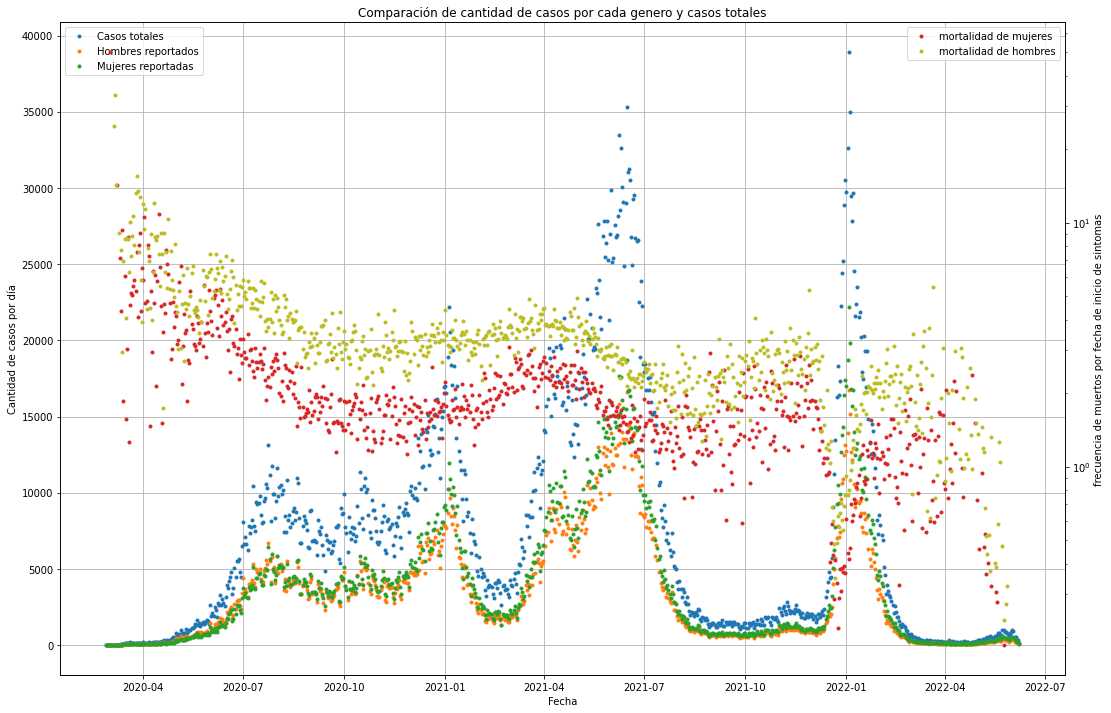

In [146]:
fig, ax1 = plt.subplots(figsize = (18,12))
ax1.plot(df_casos_por_dia['Fecha de inicio de síntomas'],df_casos_por_dia['Conteo'], label = 'Casos totales',marker = '.',linewidth = 0)
ax1.plot(df_hombres_por_dia['Fecha de inicio de síntomas'],df_hombres_por_dia['Conteo'], label = 'Hombres reportados',marker = '.',linewidth = 0)
ax1.plot(df_mujeres_por_dia['Fecha de inicio de síntomas'],df_mujeres_por_dia['Conteo'], label = 'Mujeres reportadas',marker = '.',linewidth = 0)
ax1.grid(which='both')
ax1.set_title('Comparación de cantidad de casos por cada genero y casos totales')
ax1.set_ylabel('Cantidad de casos por día')
ax1.set_xlabel('Fecha')
ax2=ax1.twinx()
ax2.set_ylabel('frecuencia de muertos por fecha de inicio de sintomas')
ax2.semilogy(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='F']['Fecha de inicio de síntomas'],df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='F']['Frecuencia_mujeres'],color = 'tab:red',marker = '.',linewidth = 0,label = 'mortalidad de mujeres')
ax2.semilogy(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='M']['Fecha de inicio de síntomas'],df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='M']['Frecuencia_hombres'],color = 'tab:olive',marker = '.',linewidth = 0,label = 'mortalidad de hombres')
ax1.legend(loc = 'upper left')
ax2.legend()

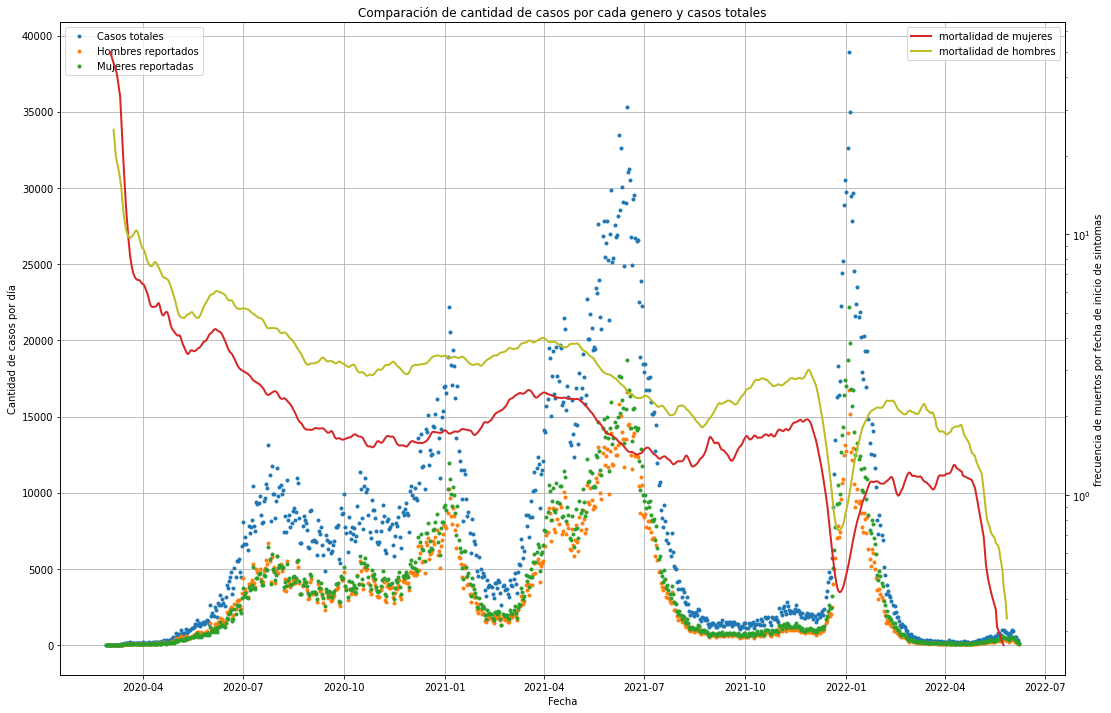

In [147]:
def filtrador(x_):
    b, a = signal.butter(1, 0.075, 'low')
    return signal.filtfilt(b, a, x_)
fig, ax1 = plt.subplots(figsize = (18,12))
ax1.plot(df_casos_por_dia['Fecha de inicio de síntomas'],df_casos_por_dia['Conteo'], label = 'Casos totales',marker = '.',linewidth = 0)
ax1.plot(df_hombres_por_dia['Fecha de inicio de síntomas'],df_hombres_por_dia['Conteo'], label = 'Hombres reportados',marker = '.',linewidth = 0)
ax1.plot(df_mujeres_por_dia['Fecha de inicio de síntomas'],df_mujeres_por_dia['Conteo'], label = 'Mujeres reportadas',marker = '.',linewidth = 0)
ax1.grid(which='both')
ax1.set_title('Comparación de cantidad de casos por cada genero y casos totales')
ax1.set_ylabel('Cantidad de casos por día')
ax1.set_xlabel('Fecha')
ax2=ax1.twinx()
ax2.set_ylabel('frecuencia de muertos por fecha de inicio de sintomas')
ax2.semilogy(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='F']['Fecha de inicio de síntomas'],filtrador(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='F']['Frecuencia_mujeres']),color = 'tab:red',linewidth = 2,label = 'mortalidad de mujeres')
ax2.semilogy(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='M']['Fecha de inicio de síntomas'],filtrador(df_mortalidad_por_sexo[df_mortalidad_por_sexo['Sexo']=='M']['Frecuencia_hombres']),color = 'tab:olive',linewidth = 2,label = 'mortalidad de hombres')
ax1.legend(loc = 'upper left')
ax2.legend()

#### 2.1. Resultados
A partir de la exploración se puede ver un que hubo un a mayor tasa de mortalidad para los hombres en la etapa inicial de la pandemia. Esto significa que esta variable debería entrar dentro de los módelos usados.

### 2.2 Diferenciación por etnias

In [148]:
df_etnia = df_casos[['Estado','Pertenencia étnica','Edad']].groupby(by=['Pertenencia étnica','Estado']).count()['Edad'].to_frame().reset_index()
df_etnia = df_etnia.rename(columns = {'Edad':'Conteo'})
display(df_etnia)
df_casos_por_etnia = df_etnia.groupby(by = ['Pertenencia étnica']).sum()['Conteo'].to_frame().reset_index()
display(df_casos_por_etnia)
df_nombres_etnias = pd.DataFrame({'Pertenencia étnica':[1,2,3,4,5,6],'Nombre_grupo':['Indígena','ROM','Raizal','Palenquero','Negro','Otro']})
df_etnia = pd.merge(df_etnia,df_casos_por_etnia,on='Pertenencia étnica',suffixes=('','_etnia'))
df_etnia = pd.merge(df_nombres_etnias,df_etnia,on='Pertenencia étnica',suffixes=('','_etnia'))
df_etnia['Frecuencia de cada estado en porcentaje'] = df_etnia['Conteo']/df_etnia['Conteo_etnia']*100
df_etnia

,Pertenencia étnica,Estado,Conteo
0,1.0,FALLECIDO,2256
1,1.0,LEVE,78878
2,2.0,FALLECIDO,6
3,2.0,LEVE,128
4,3.0,FALLECIDO,7
5,3.0,LEVE,396
6,5.0,FALLECIDO,3525
7,5.0,LEVE,131568
8,6.0,FALLECIDO,134100
9,6.0,LEVE,5728750


,Pertenencia étnica,Conteo
0,1.0,81134
1,2.0,134
2,3.0,403
3,5.0,135093
4,6.0,5862850


,Pertenencia étnica,Nombre_grupo,Estado,Conteo,Conteo_etnia,Frecuencia de cada estado en porcentaje
0,1,Indígena,FALLECIDO,2256,81134,2.780585
1,1,Indígena,LEVE,78878,81134,97.219415
2,2,ROM,FALLECIDO,6,134,4.477612
3,2,ROM,LEVE,128,134,95.522388
4,3,Raizal,FALLECIDO,7,403,1.736973
5,3,Raizal,LEVE,396,403,98.263027
6,5,Negro,FALLECIDO,3525,135093,2.609314
7,5,Negro,LEVE,131568,135093,97.390686
8,6,Otro,FALLECIDO,134100,5862850,2.287283
9,6,Otro,LEVE,5728750,5862850,97.712717


#### 2.2 Resultados
A partir de la diferencia substancial entre diferentes tasas de mortalidad de las etnías, se puede concluir, que este es un criterio significativo.

### 2.3 Diferenciación por regiones

36


,Nombre departamento,Estado,Conteo,Conteo_dpto,Mortalidad
68,VAUPES,FALLECIDO,22,1888,1.165254
34,GUAINIA,FALLECIDO,37,2753,1.343988
20,CARTAGENA,FALLECIDO,2319,157972,1.467982
56,SAN ANDRES,FALLECIDO,155,10176,1.523192
10,BOGOTA,FALLECIDO,29501,1773568,1.663370
70,VICHADA,FALLECIDO,62,3396,1.825677
38,GUAVIARE,FALLECIDO,105,5560,1.888489
2,ANTIOQUIA,FALLECIDO,18305,919948,1.989786
16,CALDAS,FALLECIDO,2529,116256,2.175372
14,BOYACA,FALLECIDO,2786,124677,2.234574


Text(0.5, 0, 'Departamento')

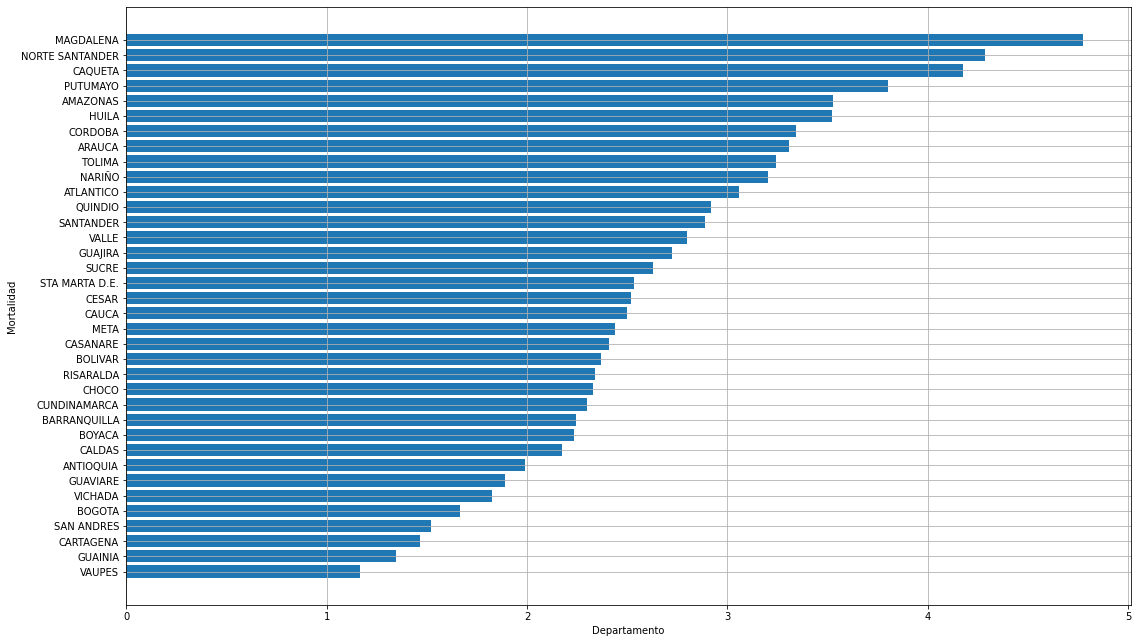

In [149]:
df_dpto = df_casos[['Estado','Nombre departamento','Edad']].groupby(by=['Nombre departamento','Estado']).count()['Edad'].to_frame().reset_index()
df_dpto = df_dpto.rename(columns = {'Edad':'Conteo'})
df_casos_por_dpto = df_dpto.groupby(by = ['Nombre departamento']).sum()['Conteo'].to_frame().reset_index()
df_dpto = pd.merge(df_dpto,df_casos_por_dpto,on = 'Nombre departamento',suffixes = ('','_dpto'))
df_dpto = df_dpto[df_dpto['Estado']=='FALLECIDO']
df_dpto['Mortalidad'] = df_dpto['Conteo']/df_dpto['Conteo_dpto']*100
df_dpto = df_dpto.sort_values(by = ['Mortalidad'])
print(len(df_dpto))
display(df_dpto)
plt.figure(figsize=(18,11))
plt.barh(df_dpto['Nombre departamento'],df_dpto['Mortalidad'])
plt.grid()
plt.ylabel('Mortalidad')
plt.xlabel('Departamento')

### 2.3 resultados 
A partir de la gráfica anterior se concluye que hay que diferenciar entre las diferentes regiones a la hora de realizar el módelo

### 2.4 Influencia de la cantidad de infectados en los ultimos 7, 14 y 21 días

In [150]:
df_muertes_por_dia = df_casos.groupby(by = ['Fecha de inicio de síntomas','Estado']).count()['Edad'].to_frame().reset_index()
df_muertes_por_dia['Estado'] = [i == 'FALLECIDO' for i in df_muertes_por_dia.Estado]# esta variable es para no tener estados moderados y graves
df_muertes_por_dia = df_muertes_por_dia.groupby(by = ['Fecha de inicio de síntomas','Estado']).sum()['Edad'].to_frame().reset_index()
df_muertes_por_dia = df_muertes_por_dia.rename(columns = {'Edad':'Conteo','Estado':'Muertos'})
df_muertes_por_dia_aux  = df_muertes_por_dia.groupby(by = ['Fecha de inicio de síntomas']).sum()['Conteo'].to_frame().reset_index() # se genera esta variable por inconsistencias
df_muertes_por_dia = pd.merge(df_muertes_por_dia,df_muertes_por_dia_aux,on = 'Fecha de inicio de síntomas',suffixes = ('','_casos'))
df_muertes_por_dia = df_muertes_por_dia[df_muertes_por_dia['Muertos'] == False].reset_index() # acá es para que se pueda recorrer el data frame sin contar los casos más de una vez
df_muertes_por_dia = df_muertes_por_dia.drop(columns = ['index'])
df_muertes_por_dia

,Fecha de inicio de síntomas,Muertos,Conteo,Conteo_casos
0,2020-02-27,False,1,1
1,2020-02-28,False,2,2
2,2020-02-29,False,2,2
3,2020-03-01,False,4,4
4,2020-03-02,False,3,4
...,...,...,...,...
827,2022-06-03,False,534,534
828,2022-06-04,False,542,542
829,2022-06-05,False,332,332
830,2022-06-06,False,364,364


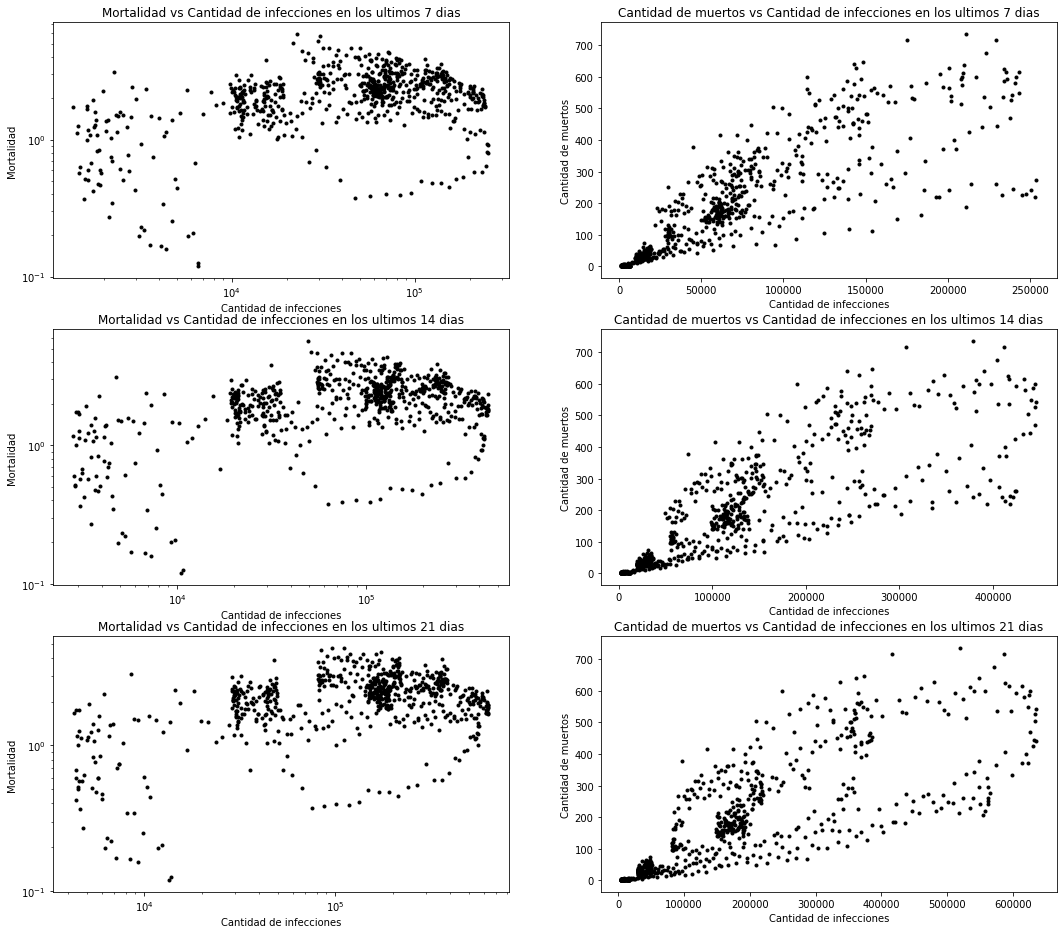

In [151]:
def casos_en_ultimos_dias (dias,cutoff):
    # para los primeros días se usara la variable NaN
    casos_en_dias = []
    muertos = []
    mortalidad = []
    for i in df_muertes_por_dia.index:
        if i > dias + cutoff:
            casos_totales = df_muertes_por_dia['Conteo_casos'].loc[i-dias:i]
            casos_totales = sum(casos_totales)
            casos_fallecidos = df_muertes_por_dia['Conteo_casos'].loc[i] - df_muertes_por_dia['Conteo'].loc[i] 
            mortalidad_dia = casos_fallecidos/df_muertes_por_dia['Conteo_casos'].loc[i]*100
            casos_en_dias.append(casos_totales)
            muertos.append(casos_fallecidos)
            mortalidad.append(mortalidad_dia)
    return casos_en_dias,muertos,mortalidad

plt.figure(figsize = (18,16))
m = 1
for cantidad_de_dias in [7,14,21]:
    casos,muertos,mortalidad = casos_en_ultimos_dias(cantidad_de_dias,100)
    plt.subplot(3,2,m)
    plt.loglog(casos,mortalidad, marker = '.',linewidth = 0,color = 'black')
    plt.ylabel('Mortalidad')
    plt.xlabel('Cantidad de infecciones')
    plt.title(f'Mortalidad vs Cantidad de infecciones en los ultimos {cantidad_de_dias} dias')
    m+=1
    plt.subplot(3,2,m)
    plt.plot(casos,muertos,linewidth = 0,color = 'black', marker = '.')
    plt.ylabel('Cantidad de muertos')
    plt.xlabel('Cantidad de infecciones')
    plt.title(f'Cantidad de muertos vs Cantidad de infecciones en los ultimos {cantidad_de_dias} dias')
    m+=1

#### 2.4 resultados
Se encontró que no hay una relación clara entre la cantidad de infecciones durante dias pasados y la mortalidad del virus

### 2.5 Edad

In [152]:
df_estados_por_edad = df_casos.groupby(by = ['Edad','Estado']).count()['ID de caso'].to_frame().reset_index()
df_estados_por_edad = df_estados_por_edad.rename(columns = {'ID de caso':'Conteo'})
df_estados_por_edad_aux = df_estados_por_edad.groupby(by = ['Edad']).sum()['Conteo'].to_frame().reset_index()
df_estados_por_edad = pd.merge(df_estados_por_edad,df_estados_por_edad_aux,on = 'Edad',suffixes = ('','_casos'))
df_estados_por_edad = df_estados_por_edad[df_estados_por_edad['Estado']=='FALLECIDO']
df_estados_por_edad['Mortalidad'] = df_estados_por_edad['Conteo']/df_estados_por_edad['Conteo_casos']*100
df_estados_por_edad

,Edad,Estado,Conteo,Conteo_casos,Mortalidad
0,1,FALLECIDO,43,27363,0.157147
2,2,FALLECIDO,30,23084,0.129960
4,3,FALLECIDO,22,21604,0.101833
6,4,FALLECIDO,20,21686,0.092225
8,5,FALLECIDO,23,22669,0.101460
...,...,...,...,...,...
210,106,FALLECIDO,9,25,36.000000
212,107,FALLECIDO,5,11,45.454545
214,108,FALLECIDO,2,8,25.000000
217,110,FALLECIDO,1,7,14.285714


Text(0.5, 1.0, 'Mortalidad vs Edad 21 dias')

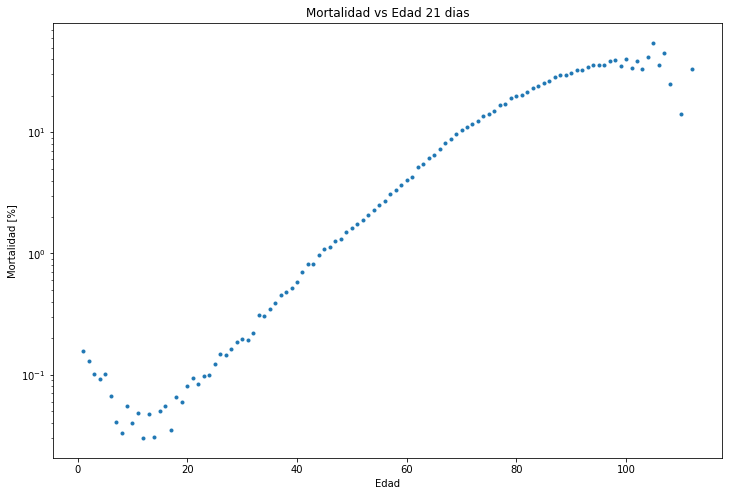

In [153]:
plt.figure(figsize = (12,8))
plt.semilogy(df_estados_por_edad['Edad'],df_estados_por_edad['Mortalidad'],linewidth = 0, marker = '.')
plt.ylabel('Mortalidad [%]')
plt.xlabel('Edad')
plt.title(f'Mortalidad vs Edad {cantidad_de_dias} dias')


#### 2.5 Resultados
Se encontró que la edad es un excelente predictor de la probabilidad de muerte.

### 2 Resultados
Se encontró que las variables significativas para diferenciar son:
* Tiempo
* Sexo
* Etnía
* Región
* Edad
Por otra parte no se tendrá en cuenta la cantidad de infectados en los ultimos 14 días
## 3 Modelos
Para los modelos se utilizaran unicamente las variables mencionadas anteriormente
### 3.1 Modelo 1
Acá la muerte se tratara como una variable aleatoria cuya probabilidad dependera exclusivamente de la mortalidad. 
Para el módelo 1 se utilizara un multiplicador generado a partir de arboles de decisiones, esto se multiplicara por un factor de edad. y un factor de tiempo. Para el factor de tiempo se usará la versión filtrada.
A(Sexo, Etnia, Region) el resultado del arbol de decisión: $$Mortalidad = A(Sexo,Etnía,Región,f_1(Edad)*f_2(Tiempo))*$$

Para generar $f_1$ se usara una regresión, dado que se puede observar una tendencia lineal entre el logaritmo de la mortalidad y la edad, se influyen las siguiente regresión:
$$log(Mortalidad) = Edad*x + c \rightarrow Mortalidad = exp(c+b*x)$$
$$f_1(Edad) = exp(c+b*x)$$
Para generar $f_2$ se usara una diccionario de una versión filtrada de la mortalidad por día, pues esto mantiene los tiempos de lectura al mínimo y minimiza el ruido.

In [154]:
# primero se genera el multiplicador de la edad
# Primero se cortan algunos datos
df_estados_por_edad = df_estados_por_edad[df_estados_por_edad['Edad']>8]
df_estados_por_edad = df_estados_por_edad[df_estados_por_edad['Edad']<80]
logy = np.log(df_estados_por_edad['Mortalidad'].values)
x = df_estados_por_edad['Edad'].values
regresion_lineal = linregress(x,logy)
b = regresion_lineal.slope
c = regresion_lineal.intercept
def f1(x):
    return np.exp(b*x +c)/mortalidad_global

    
regresion_lineal

LinregressResult(slope=0.09611771341431102, intercept=-4.417658007404711, rvalue=0.9966547867400448, pvalue=8.618477060016113e-77, stderr=0.0009488499192390536, intercept_stderr=0.04605588881705945)

En la celda a continuación se puede ver el desempeño de la función f1.

Text(0.5, 1.0, 'Mortalidad vs Edad 21 dias')

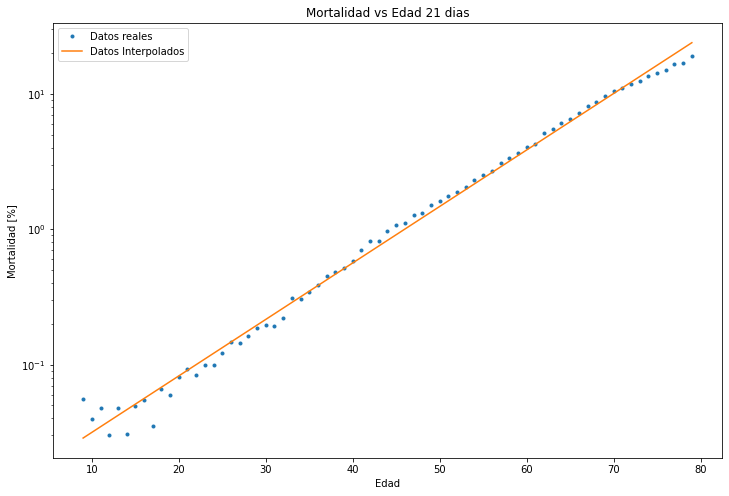

In [155]:
plt.figure(figsize = (12,8))
plt.semilogy(df_estados_por_edad['Edad'],df_estados_por_edad['Mortalidad'],linewidth = 0, marker = '.',label  = 'Datos reales')
plt.semilogy(df_estados_por_edad['Edad'].values,mortalidad_global * f1(df_estados_por_edad['Edad'].values),label = 'Datos Interpolados')
plt.legend()
plt.ylabel('Mortalidad [%]')
plt.xlabel('Edad')
plt.title(f'Mortalidad vs Edad {cantidad_de_dias} dias')

In [158]:
def gen_f2():
    mortalidades = filtrador((df_muertes_por_dia['Conteo_casos']-df_muertes_por_dia['Conteo'])/df_muertes_por_dia['Conteo']*100)
    fechas = df_muertes_por_dia['Fecha de inicio de síntomas'].values
    diccionario_respuesta = dict()
    for fecha, mortalidad in zip (fechas,mortalidades):
        diccionario_respuesta[fecha] = mortalidad/mortalidad_global
    return diccionario_respuesta
def f2(x):
    dic = gen_f2()
    respuesta = []
    for i in range(len(x)):
        if np.isnat(x[i]):
            respuesta.append(1)
        else:
            respuesta.append(dic[x[i]])
    return np.array(respuesta)

Text(0.5, 1.0, 'Mortalidad vs Fecha 21 dias')

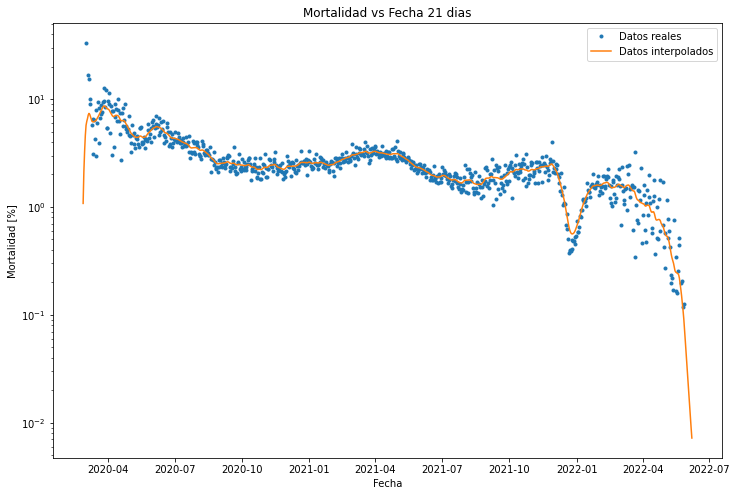

In [159]:
plt.figure(figsize = (12,8))
plt.semilogy(df_muertes_por_dia['Fecha de inicio de síntomas'],(df_muertes_por_dia['Conteo_casos']-df_muertes_por_dia['Conteo'])/df_muertes_por_dia['Conteo']*100,linewidth = 0, marker = '.',label  = 'Datos reales')
plt.semilogy(df_muertes_por_dia['Fecha de inicio de síntomas'],f2(df_muertes_por_dia['Fecha de inicio de síntomas'].values)*mortalidad_global,label = 'Datos interpolados')
plt.legend()
plt.ylabel('Mortalidad [%]')
plt.xlabel('Fecha')
plt.title(f'Mortalidad vs Fecha {cantidad_de_dias} dias')

#### Construcción del set de pruebas para arboles de decision
$$A(\bold{x}) = \frac{Mortalidad}{f_1(Edad),f_2(Tiempo)}$$

In [160]:
df_m1_pre = df_casos.groupby(by = ['Fecha de inicio de síntomas','Edad','Estado','Sexo','Nombre departamento','Pertenencia étnica']).count()['ID de caso'].to_frame().reset_index()
df_m1_pre = df_m1_pre[df_m1_pre['Fecha de inicio de síntomas'] > np.datetime64('2020-05-27 00:00:00')]
df_m1_pre = df_m1_pre.rename(columns = {'ID de caso':'Conteo'})
df_m1_pre['Mortalidad_edad'] = f1(df_m1_pre['Edad'])
df_m1_pre['Mortalidad_fecha'] = f2(df_m1_pre['Fecha de inicio de síntomas'].values)

In [162]:
df_m1_pre_v1 = df_m1_pre.groupby(by = ['Estado','Sexo','Nombre departamento','Pertenencia étnica']).sum()[['Conteo']].reset_index()
df_m1_pre_v2 = df_m1_pre.groupby(by = ['Estado','Sexo','Nombre departamento','Pertenencia étnica']).mean()[['Mortalidad_edad','Mortalidad_fecha']].reset_index()
df_m1_pre_aux = df_m1_pre.groupby(by = ['Sexo','Nombre departamento', 'Pertenencia étnica'])['Conteo'].sum().to_frame().reset_index()
df_m1_pre = pd.merge(df_m1_pre, df_m1_pre_aux,on = ['Sexo','Nombre departamento', 'Pertenencia étnica'], suffixes = ('','_total'))
df_m1_pre['Mortalidad_total'] = df_m1_pre['Conteo']/df_m1_pre['Conteo_total']
df_m1_pre = df_m1_pre[df_m1_pre['Estado']=='FALLECIDO']

In [168]:
df_m1 = df_m1_pre.drop(columns = ['Estado','Sexo','Nombre departamento','Pertenencia étnica'])
for columna in ['Estado','Sexo','Nombre departamento','Pertenencia étnica']:
    opciones = set([i for i in df_m1_pre[columna]])
    for opcion in opciones:
        df_m1[f'{columna}_{opcion}'] = [i== opcion for i in df_m1_pre[columna]]

df_m1 = df_m1.drop(columns = ['Fecha de inicio de síntomas','Edad'])

In [169]:
respuesta = df_m1['Mortalidad_total'].values
training_set = df_m1.drop(columns = ['Conteo','Conteo_total','Mortalidad_total']).to_numpy()
training_set

array([[0.29885292783910233, 2.1800699726781723, True, ..., False, False,
        True],
       [10.470394356899611, 2.1800699726781723, True, ..., False, False,
        True],
       [12.689655276909583, 2.1800699726781723, True, ..., False, False,
        True],
       ...,
       [0.5856811718314596, 1.079135908002413, True, ..., False, False,
        False],
       [4.4083138475886825, 1.081978868288368, True, ..., False, False,
        False],
       [0.05832031239177065, 1.1123179210983436, True, ..., False, False,
        False]], dtype=object)

In [170]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(training_set,respuesta)
y_pred = clf.predict(training_set)

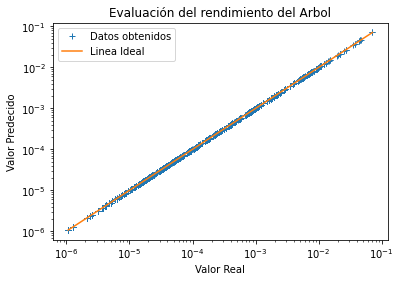

In [177]:
plt.title('Evaluación del rendimiento del Arbol')
plt.loglog(respuesta, y_pred, linewidth = 0 , marker = '+',label = 'Datos obtenidos')
plt.loglog([min(respuesta),max(respuesta)],[min(respuesta),max(respuesta)],label = 'Linea Ideal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predecido')
plt.legend()

#### 3.1 Conclusioón
 Dado que el arbol logró sacar información exacta para cada combinación, se considera que esta es la opción ideal, pues esta compuesto de valores que en su gran mayoría no dependen de interpolación, no habrá nuevos valores para las siguientes variables de los pacientes : Sexo, Fecha de inicio de sintomás, nombres de departamentos , edades y razas, se considera que este modelo es adecuado. 

### 3.2 Modelo de con Bosque aleatorio
A continuación se utilizara un modelo de bosque aleatorio. Este modelo usara el 30 % de la información e intentara predecir el 100% de la información.

In [ ]:
def partidor(df_entrada):
    df_entrada = df_entrada[['Sexo','Nombre departamento','Pertenencia étnica','Edad','Fecha de inicio de síntomas','Estado']]
    df_salida = df_entrada[['Estado','Edad','Fecha de inicio de síntomas']]
    df_salida['Fecha de inicio de síntomas'] = (df_salida['Fecha de inicio de síntomas'] - min(df_casos['Fecha de inicio de síntomas']))/np.timedelta64(1,'D')
    df_salida['Estado'] = df_salida['Estado'] == 'FALLECIDO'
    for columna in ['Sexo','Nombre departamento','Pertenencia étnica']:
        opciones = set([i for i in df_m1_pre[columna].values])
        for opcion in opciones:
            df_salida[f'{columna}_{opcion}'] = [i== opcion for i in df_entrada[columna]]
    return df_salida.dropna()
df_m2 = partidor(df_casos.sample(int(0.3*len(df_casos))))
X = df_m2.drop(columns = ['Estado']).to_numpy()
Y = df_m2['Estado']=='FALLECIDO'
Y = Y.values

/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000gn/T/ipykernel_14072/1572084869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salida['Fecha de inicio de síntomas'] = (df_salida['Fecha de inicio de síntomas'] - min(df_casos['Fecha de inicio de síntomas']))/np.timedelta64(1,'D')
/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000gn/T/ipykernel_14072/1572084869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salida['Estado'] = df_salida['Estado'] == 'FALLECIDO'
/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X,Y)

In [ ]:
df_casos_partido = partidor(df_casos)
X_tot = df_casos_partido.drop(columns = ['Estado']).to_numpy()
y_pred = clf.predict(X_tot)
df_casos_partido['Prediccion'] = y_pred

/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000gn/T/ipykernel_14072/1572084869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salida['Fecha de inicio de síntomas'] = (df_salida['Fecha de inicio de síntomas'] - min(df_casos['Fecha de inicio de síntomas']))/np.timedelta64(1,'D')
/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000gn/T/ipykernel_14072/1572084869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salida['Estado'] = df_salida['Estado'] == 'FALLECIDO'
/var/folders/pf/4qs73zlx3b70hz37p5yx4ftr0000

In [ ]:
df_evaluacion_m2 = df_casos_partido.groupby(by=['Fecha de inicio de síntomas']).count()[['Estado','Prediccion']].reset_index()

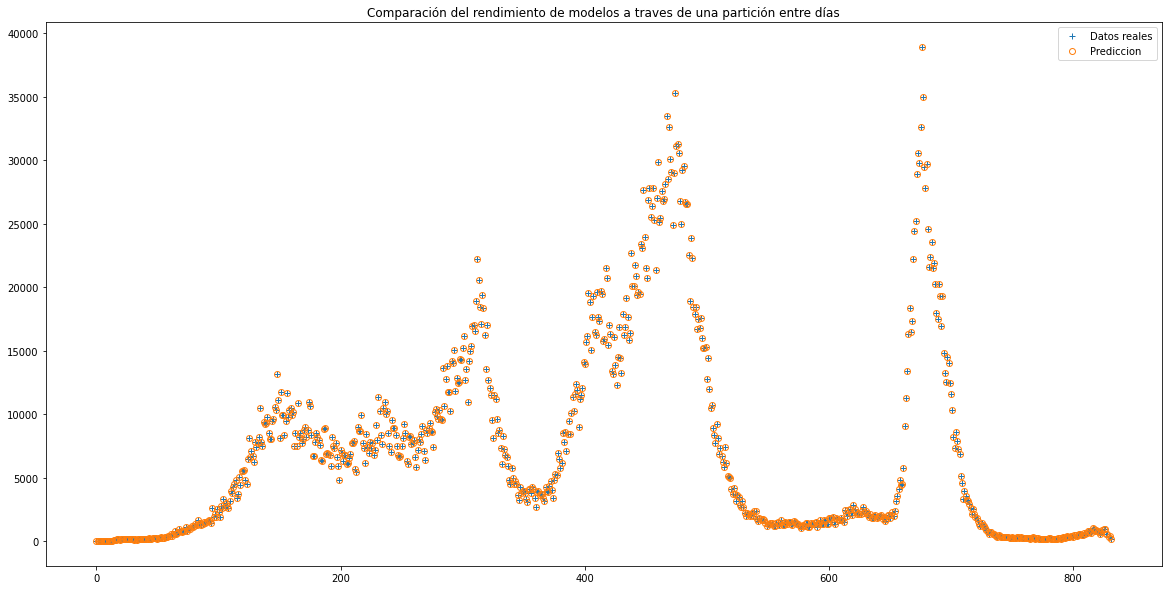

In [ ]:
plt.figure(figsize = (20,10))
plt.title ('Comparación del rendimiento de modelos a traves de una partición entre días')
plt.plot(df_evaluacion_m2['Estado'],linewidth = 0,marker = '+',label = 'Datos reales')
plt.plot(df_evaluacion_m2['Estado'],linewidth = 0,marker = 'o',fillstyle='none',label = 'Prediccion')
plt.legend()

#### 3.2 Conclusiones

Del modelo 3.2 se puede concluir que hubo overfitting con el modelo usado, esto se ve en que hay precisión extrema para absolutamente cada punto, lo anterior siginifica que este modelo puede funcionar perfectamente como interpolador pero no como predictor, pues es usual que estos modelos sacrifiquen estabilidad por precisión. Este sacrificio lleva a que estos modelos tiendan a fallar para fechas que no se hayan tenido en cuenta en el set inicial. 

## 3 Conclusion de los módelos
La conclusión de los módelos es que se usara el primer módelo, pues depende de información que no sera extrapolada.

# Conclusión del cuaderno
Se encontró que la pandemia del coronavirus afecto de formas significativamente distintas a la población, esto se puede encontrar en el análisis de datos (Punto 2). A la hora de predecir esta pandemia, el uso de módelos de machine learning resulto con tendencias hacia el overfitting. Esto se podría solucionar utilizando módelos con menor probabilidad de overfitting como lo son las redes neuronales. Desafortunadamente, debido a restricciones de tiempo, no fui capaz de introducirlos en la semana que tenía (Pues tenía un trabajo de tiempo completo).